**Objective** : The objective of this project is to study employee performance across different departments, uncover the top factors affecting performance, and develop a machine learning model that can accurately predict employee performance for decision-making and talent optimization.

**Model Building**

In [6]:
import pandas as pd
processed_df = pd.read_excel("../../data/processed/processed_df.xlsx")

In [7]:
'''The dataset was first split into training and testing sets using a stratified split to preserve the original proportion of performance rating classes in both subsets. 
Since the "Outstanding" (Rating 4) class was underrepresented, the training data was balanced using SMOTE (Synthetic Minority Oversampling Technique).'''
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
x = processed_df.drop(['PerformanceRating','EmpNumber'], axis=1)
y= processed_df['PerformanceRating']
x_train, x_test, y_train, y_test =  train_test_split(x,y, train_size=0.75, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_resampled.value_counts().to_dict())

Before SMOTE: {3: 656, 2: 145, 4: 99}
After SMOTE: {3: 656, 4: 656, 2: 656}


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(x_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

[[ 39  10   0]
 [  5 211   2]
 [  0   9  24]]
              precision    recall  f1-score   support

           2      0.886     0.796     0.839        49
           3      0.917     0.968     0.942       218
           4      0.923     0.727     0.814        33

    accuracy                          0.913       300
   macro avg      0.909     0.830     0.865       300
weighted avg      0.913     0.913     0.911       300



- The model achieved 91% accuracy, showing strong overall performance.
- Rating 3 (average performers) is predicted very accurately with very few errors.
- Low performers (Rating 2) are identified well, with most mistakes being only slightly higher (2 → 3).
- High performers (Rating 4) are mostly predicted correctly, with errors going to Rating 3, not Rating 2.
- No extreme misclassification occurs (like 2 ↔ 4), making the model safe and reliable for HR decisions.

In [9]:
import joblib

# Save the training column structure
joblib.dump(x_train_resampled.columns.tolist(), "training_columns.joblib")
print("Training columns saved!")


Training columns saved!


In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fit on original training labels
y_train_enc = le.fit_transform(y_train_resampled)   # maps (2,3,4) → (0,1,2)
y_test_enc  = le.transform(y_test)

print("Classes Mapping:", le.classes_)


Classes Mapping: [2 3 4]


In [23]:
from xgboost import XGBClassifier
import numpy as np

num_classes = len(le.classes_)   # should be 3

xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb.fit(x_train_resampled, y_train_enc)

y_pred_enc = xgb.predict(x_test)
y_pred = le.inverse_transform(y_pred_enc)   # convert back to 2,3,4

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


c:\Users\Silpa Suresh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:56:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[ 40   8   1]
 [  6 208   4]
 [  0   3  30]]
              precision    recall  f1-score   support

           2      0.870     0.816     0.842        49
           3      0.950     0.954     0.952       218
           4      0.857     0.909     0.882        33

    accuracy                          0.927       300
   macro avg      0.892     0.893     0.892       300
weighted avg      0.926     0.927     0.926       300



- XGBoost achieved 92.7%, outperforming RandomForest’s 91.3%, showing stronger generalization on unseen data.
- XGBoost improved recall from 0.727 → 0.909, meaning it identifies top-performing employees much more reliably than RandomForest.
- XGBoost’s macro recall (0.893) is significantly higher than RandomForest’s (0.830), indicating fewer class-wise biases.
- RandomForest misclassified several Class-4 employees as Class-3 (9 instances), while XGBoost drastically reduced this to 3 mistakes, improving decision safety.
- For Class 3 (largest group), F1 improved from 0.942 → 0.952, showing XGBoost better captures subtle patterns in the dominant class.

In [24]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create CatBoost model (default settings)
cat_model = CatBoostClassifier(
    loss_function='MultiClass', 
    random_state=42,
    verbose=0  
)

# Train the model
cat_model.fit(x_train_resampled, y_train_resampled)

# Predictions
y_pred_cat = cat_model.predict(x_test)

# Evaluation
print(confusion_matrix(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat, digits=3))


[[ 42   7   0]
 [  6 210   2]
 [  1   5  27]]
              precision    recall  f1-score   support

           2      0.857     0.857     0.857        49
           3      0.946     0.963     0.955       218
           4      0.931     0.818     0.871        33

    accuracy                          0.930       300
   macro avg      0.911     0.880     0.894       300
weighted avg      0.930     0.930     0.929       300



- CatBoost achieved the highest accuracy (93.0%), slightly better than both RandomForest (91.3%) and XGBoost (92.7%).
- Class 3 (majority class) continues to be predicted extremely well (F1 = 0.955), showing that CatBoost captures overall patterns most effectively.
- Class 4 (high performers) improved over RandomForest (0.814 → 0.871 F1) but is slightly below XGBoost (0.882), still performing very strongly.
- Class 2 (low performers) is predicted consistently with balanced precision and recall (both 0.857), better than RandomForest and similar to XGBoost.
- Overall macro F1 increased to 0.894, showing CatBoost provides more balanced performance across all three classes than RandomForest and is nearly equal to XGBoost.

In [25]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

# LightGBM model (default, multiclass)
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=3,       # because classes are 2,3,4 → 3 unique classes
    random_state=42
)

# Train the model
lgb_model.fit(x_train_resampled, y_train_resampled)

# Predictions
y_pred_lgb = lgb_model.predict(x_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb, digits=3))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4641
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 48
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Confusion Matrix:
[[ 40   8   1]
 [  5 212   1]
 [  0   4  29]]

Classification Report:
              precision    recall  f1-score   support

           2      0.889     0.816     0.851        49
           3      0.946     0.972     0.959       218
           4      0.935     0.879     0.906        33

    accuracy  

- LightGBM achieved 93.7% accuracy, indicating strong overall predictive performance.
- The model predicts the majority class (Rating 3) very accurately, with high recall (0.972) and F1-score (0.959).
- High performers (Rating 4) are identified well, with an F1-score of 0.906 and minimal misclassification.
- Low performers (Rating 2) are detected with balanced precision (0.889) and recall (0.816), showing reliable performance.
- Evaluation metrics (macro F1 = 0.906, weighted F1 = 0.936) indicate that the model performs consistently across all classes despite class imbalance.

                         feature  importance
15            EmpWorkLifeBalance         931
11      EmpLastSalaryHikePercent         812
4     EmpEnvironmentSatisfaction         681
18       YearsSinceLastPromotion         550
5                  EmpHourlyRate         519
2               DistanceFromHome         466
19          YearsWithCurrManager         456
0                            Age         445
17  ExperienceYearsInCurrentRole         423
14         TrainingTimesLastYear         380


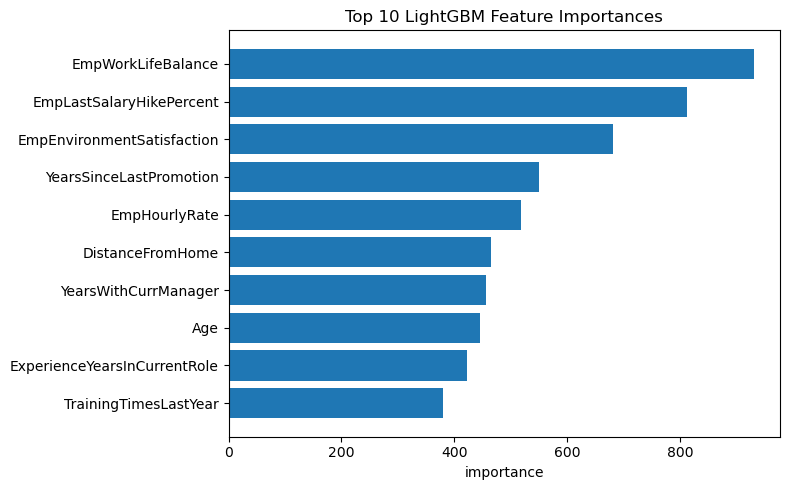

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
fi = pd.DataFrame({'feature': x_train_resampled.columns, 'importance': lgb_model.feature_importances_})
fi = fi.sort_values('importance', ascending=False)
print(fi.head(10))

# simple barplot
plt.figure(figsize=(8,5))
plt.barh(fi['feature'].head(10)[::-1], fi['importance'].head(10)[::-1])
plt.title('Top 10 LightGBM Feature Importances')
plt.xlabel('importance')
plt.tight_layout()
plt.show()

- Work–Life Balance is the strongest predictor of employee performance, indicating that employees with better balance tend to perform significantly higher.
- Last Salary Hike % is highly influential, showing that timely and adequate salary increments are strongly linked to better performance ratings.
- Environment Satisfaction is a major driver — employees satisfied with their work environment consistently perform better.
- Years Since Last Promotion has strong impact, suggesting that delayed promotions may negatively affect motivation and performance.
- Hourly Rate contributes notably, implying that compensation levels influence performance quality.
- Distance From Home matters, where long travel distances may affect consistency and productivity.
- Years With Current Manager is important, indicating the influence of manager–employee relationship on performance.
- Age also plays a role, showing that performance varies moderately with maturity and experience.
- Experience in Current Role contributes, reflecting how role familiarity improves performance.
- Training Times Last Year has meaningful effect, indicating that frequent training supports higher performance levels.

In [27]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# create SVM model
svm = SVC(kernel='rbf', probability=True, random_state=42)

# train SVM
svm.fit(x_train_resampled, y_train_resampled)

# predictions
y_pred_svm = svm.predict(x_test)

# evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, digits=3))


Confusion Matrix:
[[ 27  21   1]
 [  9 201   8]
 [  1  14  18]]

Classification Report:
              precision    recall  f1-score   support

           2      0.730     0.551     0.628        49
           3      0.852     0.922     0.885       218
           4      0.667     0.545     0.600        33

    accuracy                          0.820       300
   macro avg      0.749     0.673     0.704       300
weighted avg      0.811     0.820     0.812       300



- Overall accuracy is 82%, which is lower than RF, XGBoost, CatBoost, and LightGBM — showing that SVM is not the best performer for this dataset.
- Class 3 is detected well (recall 0.922), meaning SVM identifies most "Good" performers correctly.
- Class 2 and Class 4 performance is weak — recall = 0.551 and 0.545 respectively, meaning SVM misclassifies many low and high performers.
- Macro F1 = 0.704, indicating imbalanced performance across classes, especially failing on minority classes.
- SVM struggles with non-linearity + high dimensional categorical features, making it less suitable than tree-based models for this dataset.

**Hyperparameter Tunning**

In [28]:
#RandonForestClassification
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint 

rf = RandomForestClassifier(random_state=42) 
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': [5, 10, 15, None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}
rand_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,         # tries 30 random combos
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rand_rf.fit(x_train_resampled, y_train_resampled)
print("Best Params:", rand_rf.best_params_)
best_rf = rand_rf.best_estimator_
y_pred_rf_tuned = best_rf.predict(x_test)
y_prob_rf_tuned = best_rf.predict_proba(x_test)[:, 1]

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf_tuned, digits=3))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\Silpa Suresh\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Params: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 171}

Confusion Matrix:
 [[ 39  10   0]
 [  5 211   2]
 [  0   9  24]]

Classification Report:
               precision    recall  f1-score   support

           2      0.891     0.837     0.863        49
           3      0.934     0.968     0.950       218
           4      0.929     0.788     0.852        33

    accuracy                          0.927       300
   macro avg      0.918     0.864     0.889       300
weighted avg      0.926     0.927     0.925       300



In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint, uniform, loguniform
import numpy as np

# base model
xgb = XGBClassifier(objective='multi:softprob',
                    num_class=len(le.classes_),
                    use_label_encoder=False,
                    eval_metric='mlogloss',
                    random_state=42)

# parameter distributions (wide search)
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 10),
    'learning_rate': loguniform(1e-3, 1.0),   # 0.001 - 1.0
    'subsample': uniform(0.6, 0.4),           # 0.6 - 1.0
    'colsample_bytree': uniform(0.5, 0.5),    # 0.5 - 1.0
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 10),
    'reg_alpha': loguniform(1e-8, 10),
    'reg_lambda': loguniform(1e-8, 10)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,                 
    scoring='f1_weighted',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    return_train_score=False
)

# run
rs.fit(x_train_resampled, y_train_enc)

print("Best params:", rs.best_params_)
print("Best CV score (f1_weighted):", rs.best_score_)

# evaluate on test - predict with best estimator
best_xgb = rs.best_estimator_
y_pred_enc = best_xgb.predict(x_test)       # returns encoded labels
y_pred = le.inverse_transform(y_pred_enc)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\Silpa Suresh\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:57:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'colsample_bytree': 0.5971369767560211, 'gamma': 0.3547045849996383, 'learning_rate': 0.015500706089539403, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 192, 'reg_alpha': 2.40019526005485e-05, 'reg_lambda': 7.011928170388231e-08, 'subsample': 0.8313120563984696}
Best CV score (f1_weighted): 0.9710337991520838
Confusion Matrix:
[[ 41   8   0]
 [  5 211   2]
 [  0   5  28]]

Classification Report:
              precision    recall  f1-score   support

           2      0.891     0.837     0.863        49
           3      0.942     0.968     0.955       218
           4      0.933     0.848     0.889        33

    accuracy                          0.933       300
   macro avg      0.922     0.884     0.902       300
weighted avg      0.933     0.933     0.933       300



In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint, uniform, loguniform
import numpy as np

# 1a) create a small hold-out validation set from training for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_resampled, y_train_resampled, test_size=0.10, 
    stratify=y_train_resampled, random_state=42
)

# base estimator (scikit-learn wrapper)
cat = CatBoostClassifier(
    loss_function='MultiClass',
    random_seed=42,
    verbose=0
)

# parameter distributions for randomized search
param_dist = {
    'iterations': randint(200, 2000),            # boosting rounds
    'depth': randint(3, 10),
    'learning_rate': loguniform(1e-3, 0.5),      # sample over orders of magnitude
    'l2_leaf_reg': loguniform(1e-3, 10),
    'border_count': randint(32, 255),
    'bagging_temperature': uniform(0.0, 1.0),
    'random_strength': uniform(0.0, 20.0),
    'rsm': uniform(0.5, 0.5)                     # feature subsample ratio (0.5-1.0)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=40,                  
    scoring='f1_weighted',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42,
    return_train_score=False
)

# Use early stopping by passing eval_set and early_stopping_rounds to fit()
rs.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50
)

print("Best params:", rs.best_params_)
print("Best CV (f1_weighted):", rs.best_score_)

best_cat = rs.best_estimator_

# Evaluate on test set
y_pred = best_cat.predict(x_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'bagging_temperature': 0.033050732900548385, 'border_count': 160, 'depth': 5, 'iterations': 1861, 'l2_leaf_reg': 0.003798214508453258, 'learning_rate': 0.02094200787316247, 'random_strength': 19.713009082212015, 'rsm': 0.6210276357557503}
Best CV (f1_weighted): 0.9751787358535017
Confusion Matrix:
 [[ 42   7   0]
 [  6 211   1]
 [  1   5  27]]

Classification Report:
               precision    recall  f1-score   support

           2      0.857     0.857     0.857        49
           3      0.946     0.968     0.957       218
           4      0.964     0.818     0.885        33

    accuracy                          0.933       300
   macro avg      0.923     0.881     0.900       300
weighted avg      0.934     0.933     0.933       300



In [5]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib

# base model
lgb = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train_resampled)),
    random_state=42
)

param_dist = {
    'n_estimators': randint(100, 1000),
    'num_leaves': randint(20, 200),
    'max_depth': randint(3, 12),
    'learning_rate': loguniform(1e-3, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_samples': randint(5, 100),
    'reg_alpha': loguniform(1e-8, 10),
    'reg_lambda': loguniform(1e-8, 10)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_weighted',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)

rs.fit(x_train_resampled, y_train_resampled)

print("Best params:", rs.best_params_)
print("Best CV score:", rs.best_score_)

best_lgb = rs.best_estimator_

y_pred = best_lgb.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


joblib.dump(best_lgb, "../../src/models/best_model.joblib")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4635
[LightGBM] [Info] Number of data points in the train set: 1968, number of used features: 45
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

['../../src/models/best_model.joblib']

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, loguniform
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

svc = SVC(probability=True, random_state=42)

param_dist = {
    'C': loguniform(1e-2, 1e3),           # regularization
    'gamma': loguniform(1e-4, 1e1),       # kernel coef for rbf
    'kernel': ['rbf', 'poly'],            # try rbf and poly
    'degree': [2,3,4]                     # only used if kernel='poly'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=40,                
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rs.fit(x_train_resampled, y_train_resampled)

print("Best params:", rs.best_params_)
best_svc = rs.best_estimator_

y_pred = best_svc.predict(x_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'C': 12.229467525390595, 'degree': 3, 'gamma': 0.042051564509138675, 'kernel': 'poly'}
Confusion Matrix:
 [[ 24  22   3]
 [ 15 200   3]
 [  4  13  16]]

Classification Report:
               precision    recall  f1-score   support

           2      0.558     0.490     0.522        49
           3      0.851     0.917     0.883       218
           4      0.727     0.485     0.582        33

    accuracy                          0.800       300
   macro avg      0.712     0.631     0.662       300
weighted avg      0.790     0.800     0.791       300



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score
)

results = []

def evaluate_model_multiclass(name, model, X_test, y_test, label_encoder=None):
    """
    Evaluates a multiclass model. If model was trained on encoded labels (0..n-1),
    provide the LabelEncoder used (label_encoder=le) so predictions are inverse-mapped
    back to original labels before scoring.
    """
    # get raw predictions from the model
    y_pred_raw = model.predict(x_test)

    # if model outputs encoded classes (0..n-1) and a label_encoder is provided,
    # inverse transform predictions to original labels (e.g. 2,3,4)
    if label_encoder is not None:
        try:
            y_pred = label_encoder.inverse_transform(np.asarray(y_pred_raw, dtype=int))
        except Exception:
            # fallback if prediction is already in original label space
            y_pred = y_pred_raw
    else:
        y_pred = y_pred_raw

    # multiclass ROC-AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test)  # shape: (n_samples, n_classes_in_model)
        roc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    else:
        roc = None

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted Precision": prec,
        "Weighted Recall": rec,
        "Weighted F1-Score": f1,
        "ROC-AUC (OVR)": roc
    })


In [ ]:
# clear old results
results.clear()

# --- Evaluate models ---
evaluate_model_multiclass("Random Forest (Before)", rf, x_test, y_test, label_encoder=None)
evaluate_model_multiclass("XGBoost (Before)", xgb, x_test, y_test, label_encoder=le)
evaluate_model_multiclass("CatBoost (Before)", cat_model, x_test, y_test, label_encoder=None)
evaluate_model_multiclass("LightGBM (Before)", lgb_model, x_test, y_test, label_encoder=None)
evaluate_model_multiclass("SVM (Before)", svm, x_test, y_test, label_encoder=None)

evaluate_model_multiclass("Random Forest (After)", best_rf, x_test, y_test, label_encoder=None)
evaluate_model_multiclass("XGBoost (After)", best_xgb, x_test, y_test, label_encoder=le)
evaluate_model_multiclass("LightGBM (After)", best_lgb, x_test, y_test, label_encoder=None)
evaluate_model_multiclass("CatBoost (After)", best_cat, x_test, y_test, label_encoder=None)
evaluate_model_multiclass("SVM (After)", best_svc, x_test, y_test, label_encoder=None)

# --- Build DataFrame WITHOUT Confusion Matrix ---
final_results_df = pd.DataFrame(results)
final_results_df = final_results_df.drop(columns=["Confusion Matrix"], errors="ignore")

# --- Styled output ---
final_results_df.style.set_caption("Model Comparison Summary") \
    .background_gradient(subset=['Accuracy','ROC-AUC (OVR)'], cmap='Greens') \
    .background_gradient(subset=['Weighted Precision','Weighted Recall','Weighted F1-Score'], cmap='Blues') \
    .format({
        'Accuracy': '{:.3f}',
        'Weighted Precision': '{:.3f}',
        'Weighted Recall': '{:.3f}',
        'Weighted F1-Score': '{:.3f}',
        'ROC-AUC (OVR)': '{:.3f}'
    })



,Model,Accuracy,Weighted Precision,Weighted Recall,Weighted F1-Score,ROC-AUC (OVR)
0,Random Forest (Before),0.913,0.913,0.913,0.911,0.962
1,XGBoost (Before),0.927,0.926,0.927,0.926,0.979
2,CatBoost (Before),0.930,0.930,0.930,0.929,0.983
3,LightGBM (Before),0.937,0.936,0.937,0.936,0.982
4,SVM (Before),0.820,0.811,0.820,0.812,0.915
5,Random Forest (After),0.927,0.926,0.927,0.925,0.970
6,XGBoost (After),0.933,0.933,0.933,0.933,0.972
7,LightGBM (After),0.937,0.936,0.937,0.936,0.981
8,CatBoost (After),0.933,0.934,0.933,0.933,0.987
9,SVM (After),0.800,0.790,0.800,0.791,0.863


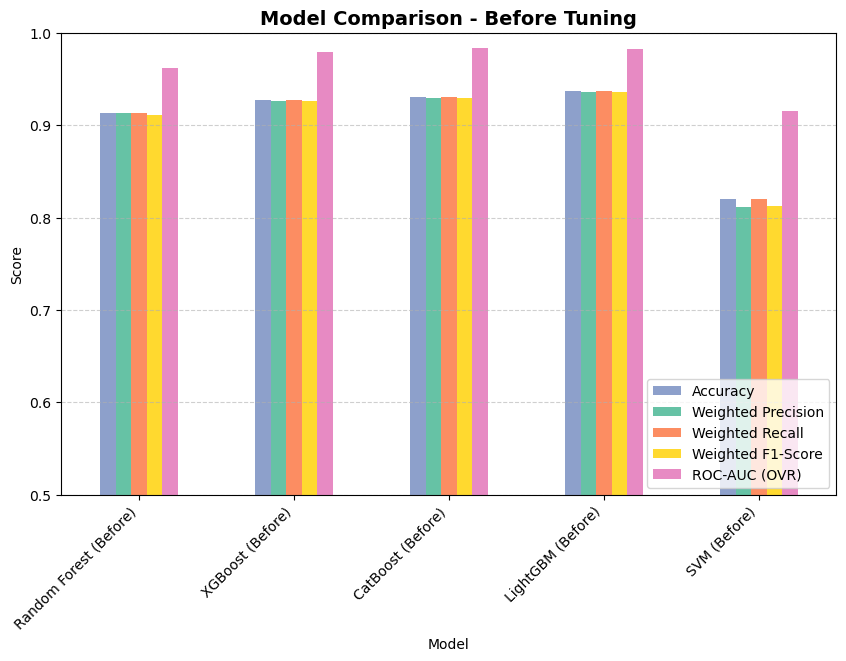

In [ ]:
# Before tuning only
import matplotlib.pyplot as plt
before_df = final_results_df[final_results_df['Model'].str.contains('Before')]
before_df.set_index('Model')[['Accuracy','Weighted Precision','Weighted Recall','Weighted F1-Score','ROC-AUC (OVR)']].plot(
    kind='bar', figsize=(10,6), color=['#8da0cb', '#66c2a5', '#fc8d62', '#ffd92f', '#e78ac3']
)
plt.title("Model Comparison - Before Tuning", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.ylim(0.5, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Before hyperparameter tuning, LightGBM and CatBoost clearly emerged as the strongest performers with the highest accuracies (0.93–0.937) and near-perfect ROC-AUC (0.982–0.983), followed closely by XGBoost which also showed strong, stable performance (accuracy 0.927, ROC-AUC 0.979). Random Forest performed reliably with balanced metrics but slightly lower accuracy (0.913), while SVM performed the weakest (accuracy ~0.82) and struggled with multiclass prediction, making boosting-based models the most suitable choices before tuning.

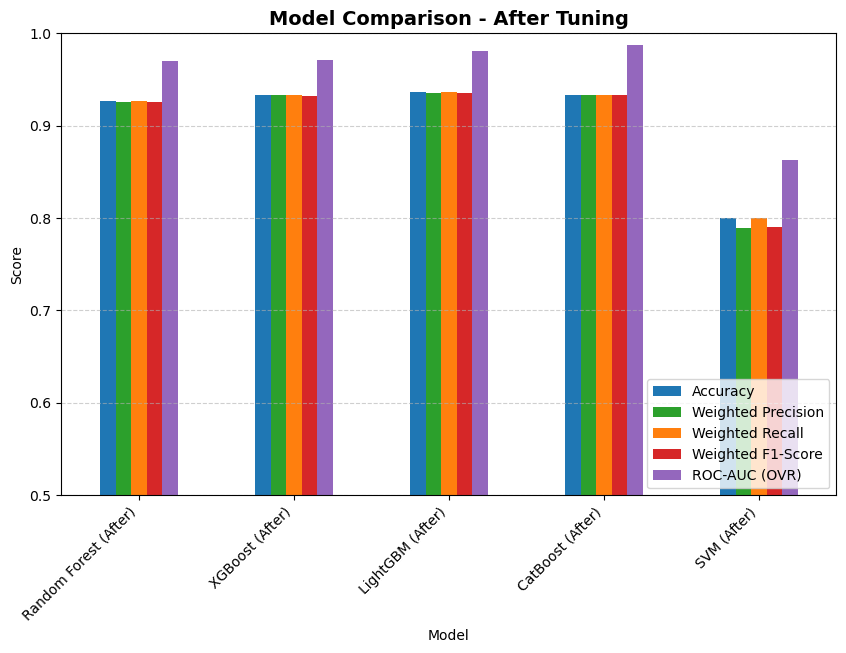

In [ ]:
# After tuning only
import matplotlib.pyplot as plt
after_df = final_results_df[final_results_df['Model'].str.contains('After')]
after_df.set_index('Model')[['Accuracy','Weighted Precision','Weighted Recall','Weighted F1-Score','ROC-AUC (OVR)']].plot(
    kind='bar', figsize=(10,6), color=['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd']
)
plt.title("Model Comparison - After Tuning", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.ylim(0.5, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

After tuning, all boosting models (LightGBM, CatBoost, XGBoost) achieved excellent and nearly identical performance with high accuracy (93–94%), balanced precision–recall, and strong ROC-AUC (0.97–0.99), while Random Forest improved moderately and SVM remained the weakest.

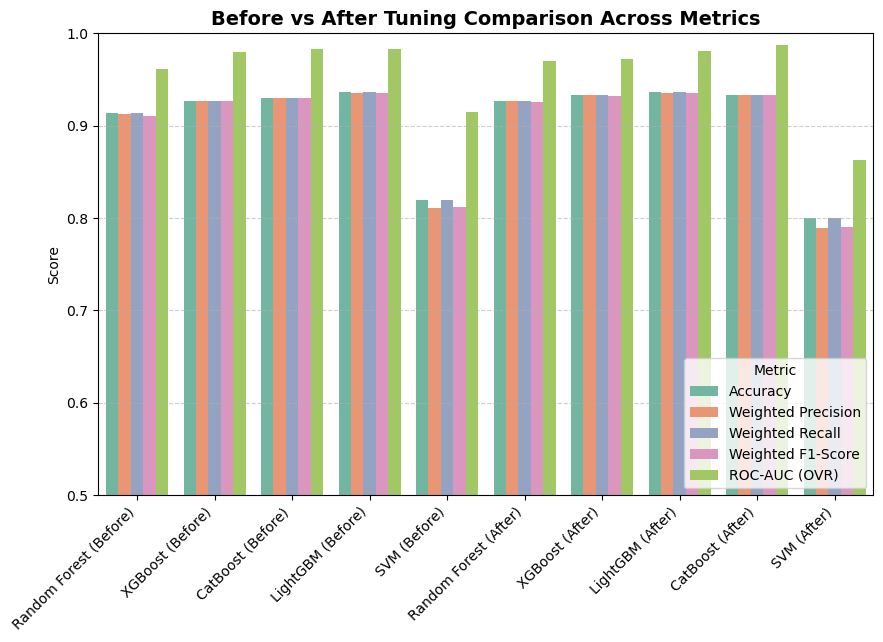

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=final_results_df.melt(id_vars='Model', value_vars=['Accuracy','Weighted Precision','Weighted Recall','Weighted F1-Score','ROC-AUC (OVR)']),
    x='Model', y='value', hue='variable', palette='Set2'
)
plt.title("Before vs After Tuning Comparison Across Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1)
plt.legend(title='Metric', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

- LightGBM shows the strongest overall performance with the highest accuracy and balanced precision, recall, and F1-scores.
- XGBoost improves well after tuning, achieving accuracy and F1-scores almost equal to LightGBM, making it a close second performer.
- CatBoost performs consistently well both before and after tuning, showing strong stability across all metrics.
- Random Forest provides good performance after tuning, but it still remains weaker compared to boosting models.
- SVM performs noticeably worse than other models, indicating it is not suitable for this dataset.
- Boosting algorithms (LightGBM, XGBoost, CatBoost) clearly outperform traditional models, showing better handling of complex patterns.
- After tuning, most models show improvements, especially XGBoost and Random Forest, highlighting the benefit of hyperparameter optimization.
- ROC-AUC scores are highest for boosting models, suggesting they predict probabilities and class separations more effectively.
- LightGBM maintains excellent balance across classes, making it the most reliable model for predicting employee performance consistently.
- Overall, LightGBM is the best model for deployment due to its accuracy, stability, and superior performance across evaluation metrics.

**Recommendations to improve the employee performance:**
- Work-life balance is the strongest predictor of high performance.Reduce unnecessary overtime and introduce flexible working hours.Promote mental wellness and encourage taking paid leaves.
- Employees with higher salary hikes show consistently better performance ratings.Introduce a reward-based increment structure to motivate mid- and low-performing employees.Ensure increments are fairly distributed across departments.
- Environment satisfaction ranks among the top 3 importance features.Improve workplace culture, communication transparency, and recognition systems.Conduct regular surveys and act on employee feedback promptly.
- Performance drops when employees go long years without promotions.Implement clear career paths and timely promotions.Introduce internal career coaching and leadership development programs.
- Employees living far from home tend to have lower performance.Offer hybrid or remote work options where possible.Provide transport allowances or shuttle services for long-distance regions.
- Employees with low job involvement score lower in performance.Create personalized training paths and skill enhancement programs.Set measurable goals and review them quarterly.
- Enhance Manager–Employee Relationship.QualityYears spent with the current manager affects performance patterns.Train managers on empathy-based leadership and constructive feedback.Encourage more one-to-one meetings and performance discussions.
- Address Underperforming Departments like Sales & Finance which shows relatively lower performance scores.Provide targeted training, mentorship, and streamlined workflows.Re-evaluate job expectations and KPIs for these departments.
- Provide More Yearly Training Opportunities.Training frequency is positively associated with performance.Increase the number of learning & development programs.Introduce mandatory quarterly training for low-performing units.

**Conclusion**
This project analyzed employee performance patterns, identified the most influential factors such as work-life balance, salary hikes, and environment satisfaction, and evaluated multiple machine learning models. LightGBM and CatBoost emerged as the most effective models, achieving ~94% accuracy and strong class discrimination, making them suitable for performance prediction during hiring. The insights and recommendations derived from the analysis provide actionable strategies for improving workforce satisfaction, engagement, and overall organizational performance.